In this blog post, I want to document how I setup a measurement of the temperature in my rice cooker during cooking.

I've owned a rice cooker since living in Japan and always enjoyed using it. But so far, I've only got a very basic understanding of its inner workings. To learn more about it, I thought that it would make for an interesting project to use an Arduino board with a temperature sensor and just put it inside the cooker during cooking. Below is a writeup of what ensued.

# Arduino setup 

The Arduino setup I've used is pretty simple, based on my [Sparkfun Inventor's kit](https://www.sparkfun.com/products/12060). I've built [the circuit that connects the TMP36 sensor](https://learn.sparkfun.com/tutorials/sik-experiment-guide-for-arduino---v32/experiment-7-reading-a-temperature-sensor) to one of the Arduino's analog port and sends the measured temperature (in degrees C) to the serial port.

In [1]:
from IPython.display import Image

In [2]:
Image(url='./pictures/outline.jpg')

A closeup of the temperature sensor is as follows:

In [3]:
Image(url='pictures/cup_zoom.jpg')

# Logging the temperature 

Once the Arduino sends the temperature signals, it's quite easy to record them using PySerial (see [here](http://playground.arduino.cc/Interfacing/Python) for getting started). I used the following code, executed as a Python standalone program in the console to log the data:

```python
# file logger.py
# run using: python logger.py
import serial
import time

try:
    ser = serial.Serial('/dev/tty.usbmodem1421')
    with open('log.txt', 'w') as f:
        f.write('time,temperature\n')
        while True:
            val = ser.readline()
            val = val.decode('utf-8')
            time_val = time.strftime("%H:%M:%S")
            f.write(",".join([time_val,
                     val]) + '\n')
            f.flush()
except KeyboardInterrupt:
    ser.close()
```

The try except structure allows me to specifically break on a Keyboard interruption and shutdown the program by closing the log.txt file.

I've also added a flush to the file everytime I receive a measurement. This is intentional and allows me to probe the resulting log.txt file in real-time.

# Temperature curves obtained

I've performed two measurements. The first one looks like this:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
import pandas as pd

/Users/kappamaki/anaconda/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


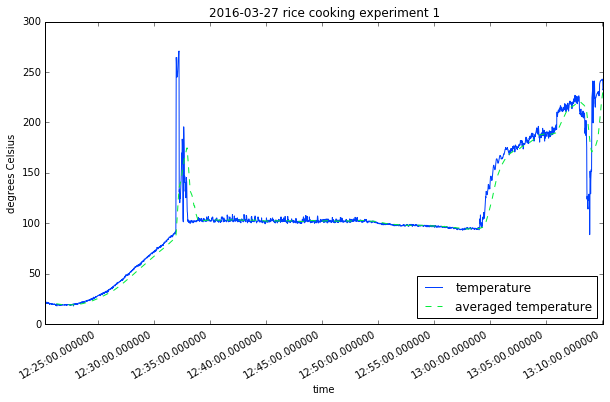

In [5]:
df = pd.read_csv('log_20160327_v1.txt', parse_dates=['time'])
df = df.set_index(df.pop('time'))
plt.figure(figsize=(10, 6))
df.temperature.plot.line(title='2016-03-27 rice cooking experiment 1')
df.temperature.rolling(window=60).mean().plot(ls='--', label='averaged temperature')
plt.ylabel('degrees Celsius')
plt.legend(loc='lower right')

As one can see, this is a little bit odd: there are spikes at 300 degrees and the temperature goes up at the end. The spikes came from water drops forming on the temperature probe. The final temperature bump was not a result of a water drop but I also believe it's a false measurement, maybe due to the probe being too wet. A picture of that situation looks like this:

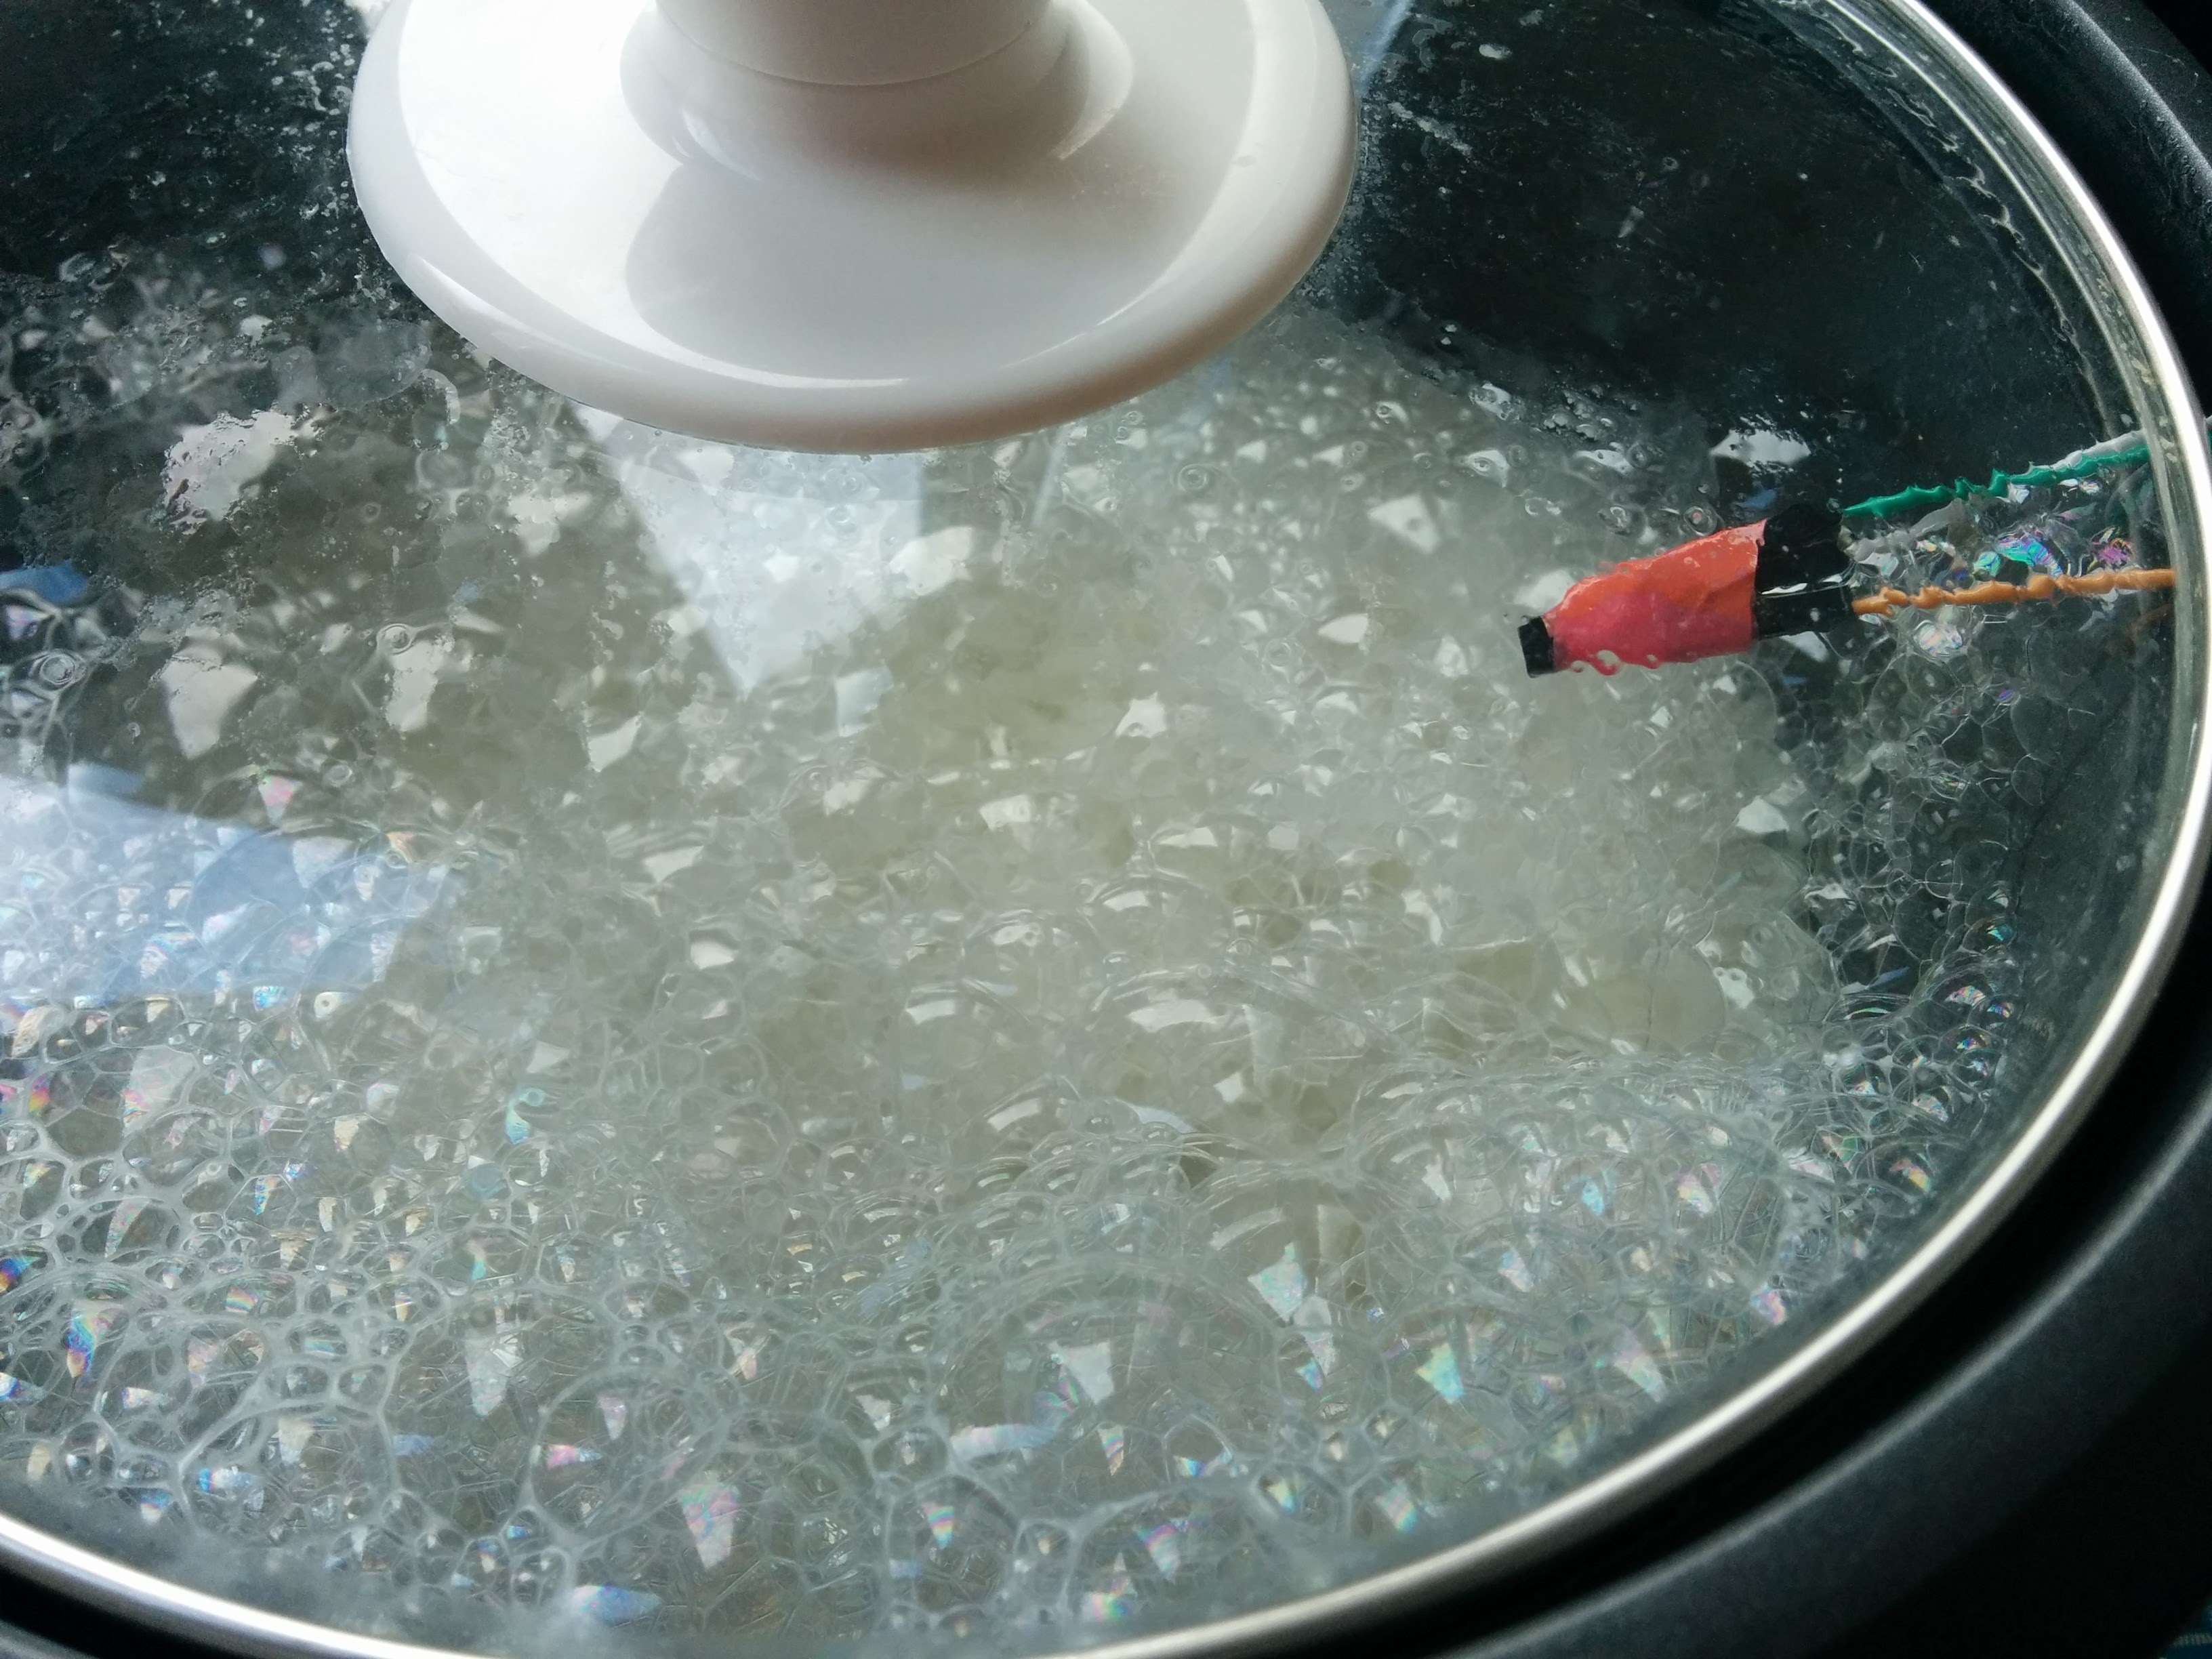

In [6]:
Image('pictures/boil2.jpg')

In a second experiment, I've wrapped the temperature probe in a thin plastic film and also managed to tilt it upwards, so that no drop could form and stay on the sensor due to gravity pull. The obtained curve looks like this:

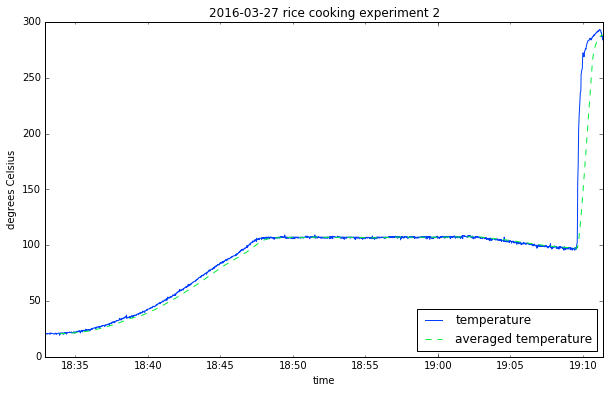

In [7]:
df = pd.read_csv('log_20160327_v2.txt', parse_dates=['time'])
df = df.set_index(df.pop('time'))
plt.figure(figsize=(10, 6))
df.temperature.plot.line(title='2016-03-27 rice cooking experiment 2')
df.temperature.rolling(window=60).mean().plot(ls='--', label='averaged temperature')
plt.ylabel('degrees Celsius')
plt.legend(loc='lower right')

Here, the final measurements are also quite strange. I would say that the valid part of the data looks like this:

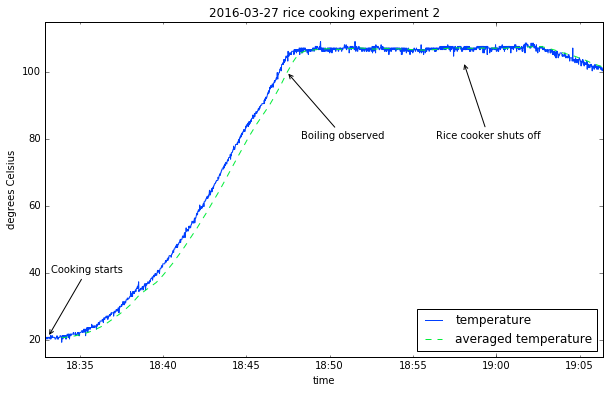

In [28]:
plt.figure(figsize=(10, 6))
df.temperature.plot.line(title='2016-03-27 rice cooking experiment 2')
df.temperature.rolling(window=60).mean().plot(ls='--', label='averaged temperature')
plt.xlim(1459189976.0, 1459191985.0)
plt.ylim(15, 115)
plt.ylabel('degrees Celsius')
plt.legend(loc='lower right')
plt.annotate("Cooking starts",
            xy=(1459189986.0, 21), xycoords='data',
            xytext=(1459189996, 40), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
plt.annotate("Boiling observed",
            xy=(1459190846.0, 100), xycoords='data',
            xytext=(1459190896.0, 80), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
plt.annotate("Rice cooker shuts off",
            xy=(1459191482.0, 103), xycoords='data',
            xytext=(1459191382.0, 80), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

This leaves use with some interesting questions on the physics of cooking rice, which we'll discuss in the next section.

# The physics of cooking rice 

So what's a rice cooker exactly? And why is what we've measured above useful in understanding it?

To start, a rice cooker is essentially a device that allows you to heat water, which then evaporates and in this process transfers heat to the rice and cooks it. If you don't know what a rice cooker looks like (both from the outside and inside) have a look at the following disassembling video:



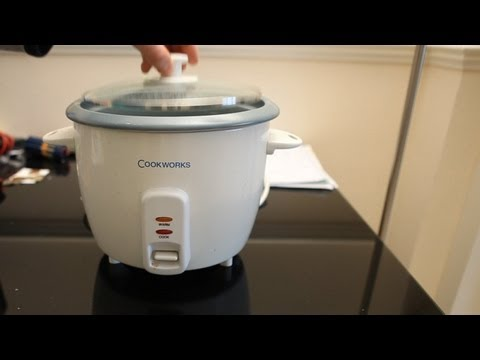

In [30]:
from IPython.display import YouTubeVideo
YouTubeVideo('LvwRkowNUK4')

One of the things that's not mentioned in this video is that a rice cooker stops to cook when all of the water is evaporated. If you look at the curve of experiment 2 above, you'll see that the there's no event of significance measured by the temperature probe at the moment the rice cooker shuts down and switches to warming instead of cooking. I'm guessing that this comes from the fact that I'm really measuring the temperature of a mixture of hot air and water vapor, not the temperature at the bottom of the pot, which should rapidly increase once all the water is evaporated.

# Towards a physical model of this rice cooker? 

At this point, my inner physicist thinks that it would be good move to develop a model of this rice cooker, as simple as it possible. To do that the questions to answer are:

- how much heat is generated by the heating element in the rice cooker?
- what chemical reaction describes the cooking of the rice?
- what happens at the bottom of the pot when bubbles of water form? 
- of what relative quantities consists the mixture of air and water vapor above the rice?
- can we predict the cooking time as a function of the rice and water quantity?

Further experiments could include: 

- opening up the rice cooker and looking at the inside
- measuring the temperature somewhere else, at the bottom of the pot for instance

Hopefully, I'll be able to shed some light on these questions in the coming days.